In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.mixture import GaussianMixture 
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth
import itertools
from tqdm import tqdm


## Clustering of Merchants
### **Objective**: Perform a hard clustering on the merchants to obtain 3 to 5 clusters, which can be used for market segmentation
### **Clustering pipeline**:
 0. Preliminary Data Analysis
 1. Data Clustering
    1. K-means
    2. MeanShift
    3. DBSCAN
    4. Gaussian Mixture Model
 2. Clustering Evaluation
    1. Silhouette Coefficient
    2. Calinski-Harabasz Index
    3. Davies-Bouldin Index
 3. Clustering Model Deployment


In [2]:
# 需要改的地方
dfs = [pd.read_csv("agg_transaction_train_sdf.csv"),
       pd.read_csv("agg_transaction_pred_sdf.csv")
       ]

merchant_df = pd.concat(dfs)
merchant_df = merchant_df[["merchant_abn",
                           "distinct_monthly_consumer_count",
                           "monthly_order_count",
                           "monthly_revenue"
                           ]]
merchant_df.head(5)

,merchant_abn,distinct_monthly_consumer_count,monthly_order_count,monthly_revenue
0,10023283211,2303,3839,8.331768e+05
1,10342410215,615,988,3.827461e+05
2,10346855916,4,7,2.003935e+04
3,10385163239,56,93,3.122719e+04
4,10648956813,11769,25654,1.655961e+06


### **PDA**

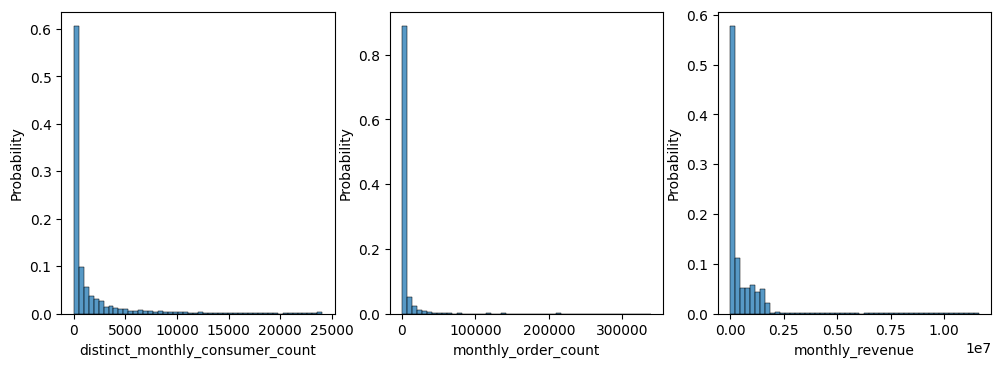

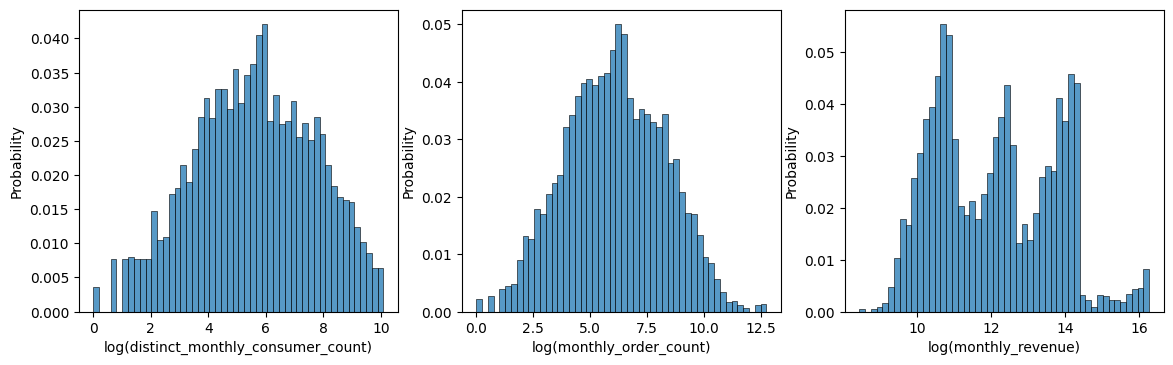

In [3]:
# 需要改的地方
features = ["distinct_monthly_consumer_count",
            "monthly_order_count",
            "monthly_revenue"
            ]

fig, ax = plt.subplots(1, 3, figsize = (12, 4), dpi = 100)
for i in range(len(features)):
    sns.histplot(merchant_df[features[i]], 
                stat = 'probability', 
                bins=50,
                ax = ax[i])


# It seems that we can perform GMM on log(features)
fig, ax = plt.subplots(1, 3, figsize = (14, 4), dpi = 100)
for i in range(len(features)):
    sns.histplot(merchant_df[features[i]].apply(np.log), 
                stat = 'probability', 
                bins=50,
                ax = ax[i])
    ax[i].set_xlabel(f'log({ax[i].get_xlabel()})')

### **Clustering**

In [4]:
X = merchant_df[features]

def homemade_GridSearch(model, parameters, data, eval_metrics=[silhouette_score, davies_bouldin_score]):
    """
    return a dataframe showing the gridsearch result
    """
    # Name of the parameters
    parameter_names = list(parameters.keys())
    # Name of the evaluation metrics
    eval_metric_names = ['silhouette_score', 'davies_bouldin_score']

    # Store the performance in a dict
    performance_dict = {parameter: [] for parameter in parameter_names + eval_metric_names + ["num_clusters"]}

    for parameter_value in tqdm(itertools.product(*map(parameters.get, list(parameter_names)))):
        # Store the combination of parameters in a dict
        parameter_set = dict(zip(parameter_names, parameter_value))
        labels = model.set_params(**parameter_set).fit_predict(data)
        # Store the parameters and corresponding score
        for parameter_name in parameter_names:
            performance_dict[parameter_name].append(parameter_set[parameter_name])
        for eval_metric_name, eval_metric in zip(eval_metric_names, eval_metrics):
            performance_dict[eval_metric_name].append(eval_metric(data, labels))
       
        # Add an additional column indicating the number of clusters
        performance_dict["num_clusters"].append(len(np.unique(labels)))

    return pd.DataFrame(performance_dict)
       


### K-Means

In [5]:
k_mean_params = {
    'n_clusters': [3, 4, 5],
    'random_state': [2022, ]
}
homemade_GridSearch(KMeans(), k_mean_params, X)

3it [00:01,  2.32it/s]


,n_clusters,random_state,silhouette_score,davies_bouldin_score,num_clusters
0,3,2022,0.764106,0.370593,3
1,4,2022,0.770670,0.433804,4
2,5,2022,0.772810,0.435790,5


### MeanShift

In [6]:
mean_shift_params = {
     'bandwidth': [estimate_bandwidth(X, quantile=q) for q in np.linspace(0.1, 0.9, num=5)]
     }

homemade_GridSearch(MeanShift(), mean_shift_params, X)

5it [01:19, 15.92s/it]


,bandwidth,silhouette_score,davies_bouldin_score,num_clusters
0,2.859949e+05,0.733362,0.502257,22
1,4.972867e+05,0.672287,0.528158,10
2,6.147371e+05,0.633885,0.502124,10
3,8.337831e+05,0.651980,0.521520,7
4,1.459107e+06,0.857314,0.445283,4


### DBSCAN

In [7]:
dbscan_params = {
    'eps': [10, 20, 40, 80, 120, 180],
    'min_samples': [1, 2, 3]
}
homemade_GridSearch(DBSCAN(), dbscan_params, X)

18it [00:20,  1.13s/it]


,eps,min_samples,silhouette_score,davies_bouldin_score,num_clusters
0,10,1,0.007234,0.003176,4394
1,10,2,-0.583680,1.189562,20
2,10,3,-0.572114,1.188631,3
3,20,1,0.027851,0.014122,4324
4,20,2,-0.623424,1.191728,81
5,20,3,-0.581420,1.193741,10
6,40,1,0.069363,0.040009,4125
7,40,2,-0.691531,1.178747,210
8,40,3,-0.533252,1.168277,56
9,80,1,0.117461,0.074540,3647


### Gaussian Mixture Model

In [8]:
log_X = X.apply(np.log)

gmm_params = {
    'n_components': [3, 4, 5],
    'init_params': ['kmeans', 'random'],
    'random_state': [2022, ]
}

display(homemade_GridSearch(GaussianMixture(), gmm_params, X))
homemade_GridSearch(GaussianMixture(), gmm_params, log_X)

6it [00:03,  1.68it/s]


,n_components,init_params,random_state,silhouette_score,davies_bouldin_score,num_clusters
0,3,kmeans,2022,0.410469,1.234209,3
1,3,random,2022,0.411411,1.233207,3
2,4,kmeans,2022,0.329399,1.383918,4
3,4,random,2022,0.329526,1.370623,4
4,5,kmeans,2022,0.081892,1.558946,5
5,5,random,2022,0.076452,2.575586,5


6it [00:03,  1.90it/s]


,n_components,init_params,random_state,silhouette_score,davies_bouldin_score,num_clusters
0,3,kmeans,2022,0.272863,0.733449,3
1,3,random,2022,0.222406,8.289280,3
2,4,kmeans,2022,0.300080,0.838844,4
3,4,random,2022,0.210621,4.355331,4
4,5,kmeans,2022,0.284131,0.871499,5
5,5,random,2022,0.290298,4.480901,5


### Cluster Visualization

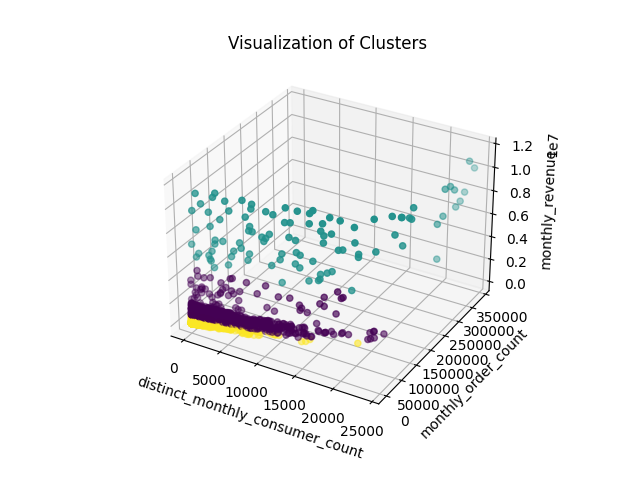

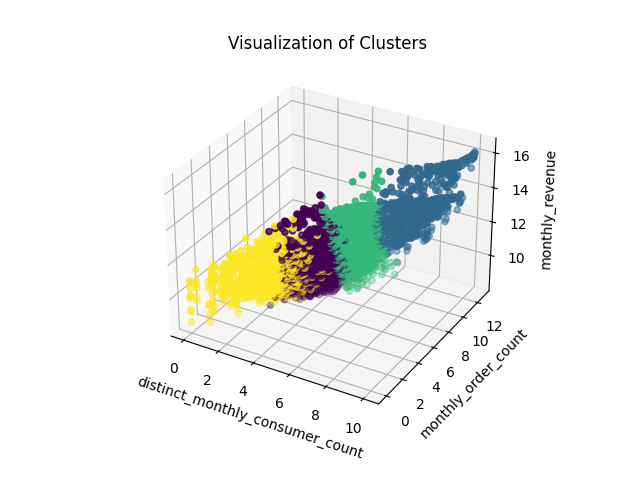

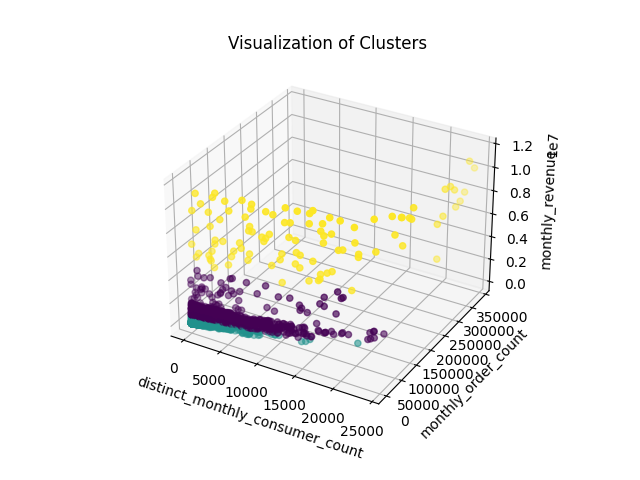

In [11]:
# 需要改的地方
%matplotlib ipympl

def visualize_cluster(model, data):
    """
    return a figure of clusters
    """
    # Define X, Y and Z axes
    xs = data["distinct_monthly_consumer_count"]
    ys = data["monthly_order_count"]
    zs = data["monthly_revenue"]
    
    # Clusters of the data
    data["cluster"] = model.fit_predict(data)

    # Create a figure
    figure = plt.figure(dpi = 100)
    ax = figure.add_subplot(projection='3d')
    ax.scatter(xs, ys, zs, c=data["cluster"])

    ax.set_title("Visualization of Clusters")
    ax.set_xlabel("distinct_monthly_consumer_count")
    ax.set_ylabel("monthly_order_count")
    ax.set_zlabel("monthly_revenue")
    
    return figure

fg1 = visualize_cluster(KMeans(n_clusters = 3), X)
fg2 = visualize_cluster(GaussianMixture(n_components=4, init_params='kmeans'), log_X)
fg3 = visualize_cluster(GaussianMixture(n_components=3, init_params='kmeans'), X)